In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(130298)

In [2]:
%pwd

'/Users/Nicole/github/heart-failure-project'

# Dataset importing and NAs identification

Looking at the variables one at a time, in the notebook "1_Data preprocessing and cleaning", we highlighted some values which were likely miswritten. We identified the value 'Unknown' to be recognized as a missing value and same for all patients for which a value of 0 was reported, where it is not physically possible. Also some unlikely values in weight and height will be substituted by missing values, as they represent biased information. For more detailed explanations on these choices, see the notebook previously cited.

In [3]:
sentinels={'DestinationDischarge':['Unknown'], 'occupation':['NA'], 
          'pulse':[0],'respiration':[0], 'systolic.blood.pressure':[0],
          'diastolic.blood.pressure':[0], 'map':[0], 'weight':[0,8],
           'height':[0.35,0.48,0.6], 'left.ventricular.end.diastolic.diameter.LV':[0]
          }

df = pd.read_csv('dat.csv', na_values=sentinels)
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.set_index('inpatient.number', inplace = True)
df.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat
inpatient.number,,,,,,,,,,,,,,,,,,,,,
857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87.0,19.0,...,37.0,97.0,93.0,95.9,17.8,1.14,125.0,15,11,"(69,79]"
743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]"
866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(59,69]"
775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]"
810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(69,79]"


We remove the columns with more than 50% of missing values, as no gain would come if we would impute their values due to the quantity.

In [4]:
missing_perc = df.isnull().sum()/len(df)
columns_missing = df.columns[np.where(missing_perc>0.5)]
print(f"Number of columns dropped: {len(columns_missing)}")
data = df.copy()
data.drop(columns = list(columns_missing), inplace = True)
print(f"Current number of features: {data.shape[1]}")

Number of columns dropped: 43
Current number of features: 122


## Splitting dataset in training and test set using a stratified sampling

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, data["re.admission.within.6.months"]):
    X_train = data.iloc[train_index].copy()
    X_test = data.iloc[test_index].copy()

In [6]:
X_train.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,total.bilirubin,total.bile.acid,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay,ageCat
inpatient.number,,,,,,,,,,,,,,,,,,,,,
734179,Home,Cardiology,NonEmergency,farmer,Cardiology,1,Female,36.3,80.0,19.0,...,33.1,14.0,75.1,3.30,1.87,0.64,0.92,15,13,"(59,69]"
772351,Home,Cardiology,Emergency,farmer,Cardiology,1,Male,36.6,83.0,19.0,...,11.0,3.9,66.2,4.24,2.58,1.03,1.12,15,7,"(49,59]"
836826,Home,Cardiology,NonEmergency,farmer,Cardiology,1,Male,36.0,96.0,18.0,...,37.2,1.7,65.8,2.44,1.00,0.62,0.95,15,7,"(69,79]"
764082,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Female,37.0,90.0,19.0,...,7.3,NaN,79.4,2.85,1.58,1.31,0.85,15,5,"(69,79]"
789038,HealthcareFacility,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.0,82.0,21.0,...,39.7,5.1,74.0,3.30,1.52,2.13,0.98,15,8,"(59,69]"


In [7]:
X_train.shape

(1606, 122)

In [8]:
X_test.shape

(402, 122)

# Analysis of the variance of the features
We want to know if some features have 0 (or almost 0) variance, to exclude them from the models apriori. Indeed, a variable which has no dispersion in its values, cannot be used to explain the variability in another variable. 
In the previous histplots, we realized that some of the 0/1 categorical variables have very few cases of one of the two categories. The names of these are stored in the list "col_to_exclude" and with a variance analysis we will see that their variance is almost 0. We choose $\tau$ = 0.05 as a threshold.

In [9]:
variance = X_train.var()
col_to_exclude = list(variance[variance < 0.05].index)
col_to_exclude

/var/folders/wv/3nl79hln39v6l6d2kr7f6zj80000gn/T/ipykernel_18945/1845861563.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variance = X_train.var()


['height',
 'peripheral.vascular.disease',
 'connective.tissue.disease',
 'peptic.ulcer.disease',
 'hemiplegia',
 'leukemia',
 'malignant.lymphoma',
 'solid.tumor',
 'liver.disease',
 'AIDS',
 'acute.renal.failure',
 'death.within.28.days',
 'death.within.3.months',
 'death.within.6.months',
 'monocyte.ratio',
 'hematocrit',
 'basophil.ratio',
 'basophil.count',
 'eosinophil.ratio',
 'platelet.hematocrit',
 'neutrophil.ratio',
 'calcium',
 'creatine.kinase.isoenzyme.to.creatine.kinase',
 'hydroxybutyrate.dehydrogenase.to.lactate.dehydrogenase']

In [10]:
X_train.drop(columns = col_to_exclude, inplace = True)
print(f"Current number of features in training set: {X_train.shape[1]}")

Current number of features in training set: 98


In [11]:
X_test.drop(columns = col_to_exclude, inplace = True)
print(f"Current number of features in test set: {X_test.shape[1]}")

Current number of features in test set: 98


## Remove patients who died before leaving the hospital
For sure we don't need in the prediction of the outcome of readmission at 6 months patients who died before leaving the hospital in the first place. We notice that there are two variables defining patients who died.

In [12]:
X_train['DestinationDischarge'].value_counts()

Home                  1078
HealthcareFacility     343
Died                    12
Name: DestinationDischarge, dtype: int64

In [13]:
X_train['outcome.during.hospitalization'].value_counts()

Alive                    1509
DischargeAgainstOrder      87
Dead                       10
Name: outcome.during.hospitalization, dtype: int64

In [14]:
def remove_dead_patient(data):
    dead_patients_id_1 = list(data.index[data['DestinationDischarge'] == 'Died'])
    dead_patients_id_2 = list(data.index[data['outcome.during.hospitalization'] == 'Dead'])
    dead_patients_id = union(dead_patients_id_1, dead_patients_id_2)
    return dead_patients_id

def union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list



In [15]:
dead_patient_train = remove_dead_patient(X_train)
data.loc[dead_patient_train][['eye.opening','movement','verbal.response','GCS']]                                       

,eye.opening,movement,verbal.response,GCS
inpatient.number,,,,
828678,2,5,4,11
834443,1,1,1,3
868748,4,6,5,15
768336,4,6,5,15
728787,3,6,4,13
869467,4,6,5,15
773090,4,6,5,15
805475,1,1,1,3
753570,4,6,5,15


There are 14 patients which did not make it out of the hospital. We notice that 4 of these patients were in a coma and had very severe conditions (see eye.opening and the other characteristics above).
Moreover most of the patients were fully responsive but died anyway.

In [16]:
X_train.drop(dead_patient_train, inplace = True)

In [17]:
dead_patient_test = remove_dead_patient(X_test)
data.loc[dead_patient_test][['eye.opening','movement','verbal.response','GCS']]

,eye.opening,movement,verbal.response,GCS
inpatient.number,,,,
773886,4,6,5,15
765343,1,1,1,3


In [18]:
X_test.drop(dead_patient_test, inplace = True)

# Removing problematic rows
In file '1_Data preprocessing' we spotted some problematic rows, where patients, for example have an impossible weight or other impossible values. We already substituted these missing values with NaN. Now we want to remove patients where more than 25% of features are NaN, as too little information is known on these patients to actually be beneficial in the analysis.

In [19]:
def drop_problematic_rows(data):
    problematic_rows=[]
    for i in range(data.shape[0]):
        sum_null=data.iloc[i].isnull().sum()
        perc_null=sum_null/data.shape[1]
        if perc_null>0.25:
            problematic_rows.append(data.index[i])
    return problematic_rows
    

In [20]:
problematic_rows_train = drop_problematic_rows(X_train)
len(problematic_rows_train)

20

In [21]:
X_train.drop(problematic_rows_train, inplace = True)

In [22]:
problematic_rows_test = drop_problematic_rows(X_test)
len(problematic_rows_test)

2

In [23]:
X_test.drop(problematic_rows_test, inplace = True)

# Categorical Variables

The variable 'visit.times' it's ordinal, and it will be kept as such in the one-hot encoding since its values are numerical. The same goes for 'eye.opening','verbal.response', 'movement', 'GCS' and 'CCI.score', whose meaning is explained in the file "1_Data preprocessing".

We will distinguish categorical and binary vairables, as the latter do not need one-hot encoding. This will be an advantage since less columns will be required.

In [24]:
categorical_columns = ['DestinationDischarge','admission.ward','admission.way','occupation','discharge.department',
                       'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',
                       'consciousness', 'outcome.during.hospitalization','ageCat']

ordinal_columns = ['visit.times', 'CCI.score', 'eye.opening','verbal.response', 'movement', 'GCS']

not_continuous = categorical_columns.copy()

binary_columns = ['gender', 'myocardial.infarction', 'congestive.heart.failure',
                  'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease',
                  'diabetes', 'moderate.to.severe.chronic.kidney.disease',
                  'type.II.respiratory.failure', 'oxygen.inhalation', 're.admission.within.28.days', 
                  're.admission.within.3.months', 're.admission.within.6.months',
                  'return.to.emergency.department.within.6.months','respiratory.support.']
# NB 'respiratory.support.' is in the binary variables because we will rebin it in 0/1

not_continuous.extend(binary_columns)
not_continuous.extend(ordinal_columns)

In [25]:
# list of the columns with continuous variables, all those not included in the previous
continuous_columns = [col_name for col_name in X_train.columns if col_name not in not_continuous]

## Assess whether the variable with unbalanced category are unbalanced also in the outcome
Before proceeding to One-hot econding, we want to see whether all the categorical variables are useful for our study. In particular, in the initial analysis, we noticed that some features are particularly unbalanced. Let's put together all categorical features and see if one category represents more than 80% of the total values of the variables.

In [26]:
cat_columns = not_continuous.copy()

unbalanced_cols=[]
for col_name in cat_columns:
    max_value = (X_train[col_name].value_counts()/X_train.shape[0]).max()
    if max_value>0.8 and col_name!= "death.within.28.days" and col_name!= "re.admission.within.28.days" and col_name!= "death.within.3.months"and col_name!= "death.within.6.months":
        print(col_name,': ',max_value)
        unbalanced_cols.append(col_name)


occupation :  0.8263358778625954
discharge.department :  0.8422391857506362
consciousness :  0.9860050890585241
outcome.during.hospitalization :  0.94529262086514
myocardial.infarction :  0.928117048346056
congestive.heart.failure :  0.9319338422391857
cerebrovascular.disease :  0.926208651399491
dementia :  0.9402035623409669
Chronic.obstructive.pulmonary.disease :  0.8893129770992366
type.II.respiratory.failure :  0.9446564885496184
oxygen.inhalation :  0.9459287531806616
respiratory.support. :  0.9821882951653944
visit.times :  0.9300254452926209
eye.opening :  0.9840966921119593
verbal.response :  0.9821882951653944
movement :  0.9790076335877863
GCS :  0.9751908396946565


Now, for each of the variables with more of 80% of unbalance in a category, we want to see whether their values are equally distributed among the two groups defined by the outcome "Readmitted within 6 months". If a variable has a category which strongly follows the target (e.g., that category is always present when target = 1, i.e. ~100% of the cases of the category coincide with an outcome = 1, or viceversa) then it might be significant in the final study, even if it is highly unbalanced. We will store in a list all variables whose categories are equally distributed among the outcome groups.

In [27]:
balanced_in_outcome = []
outcome_name="re.admission.within.6.months"

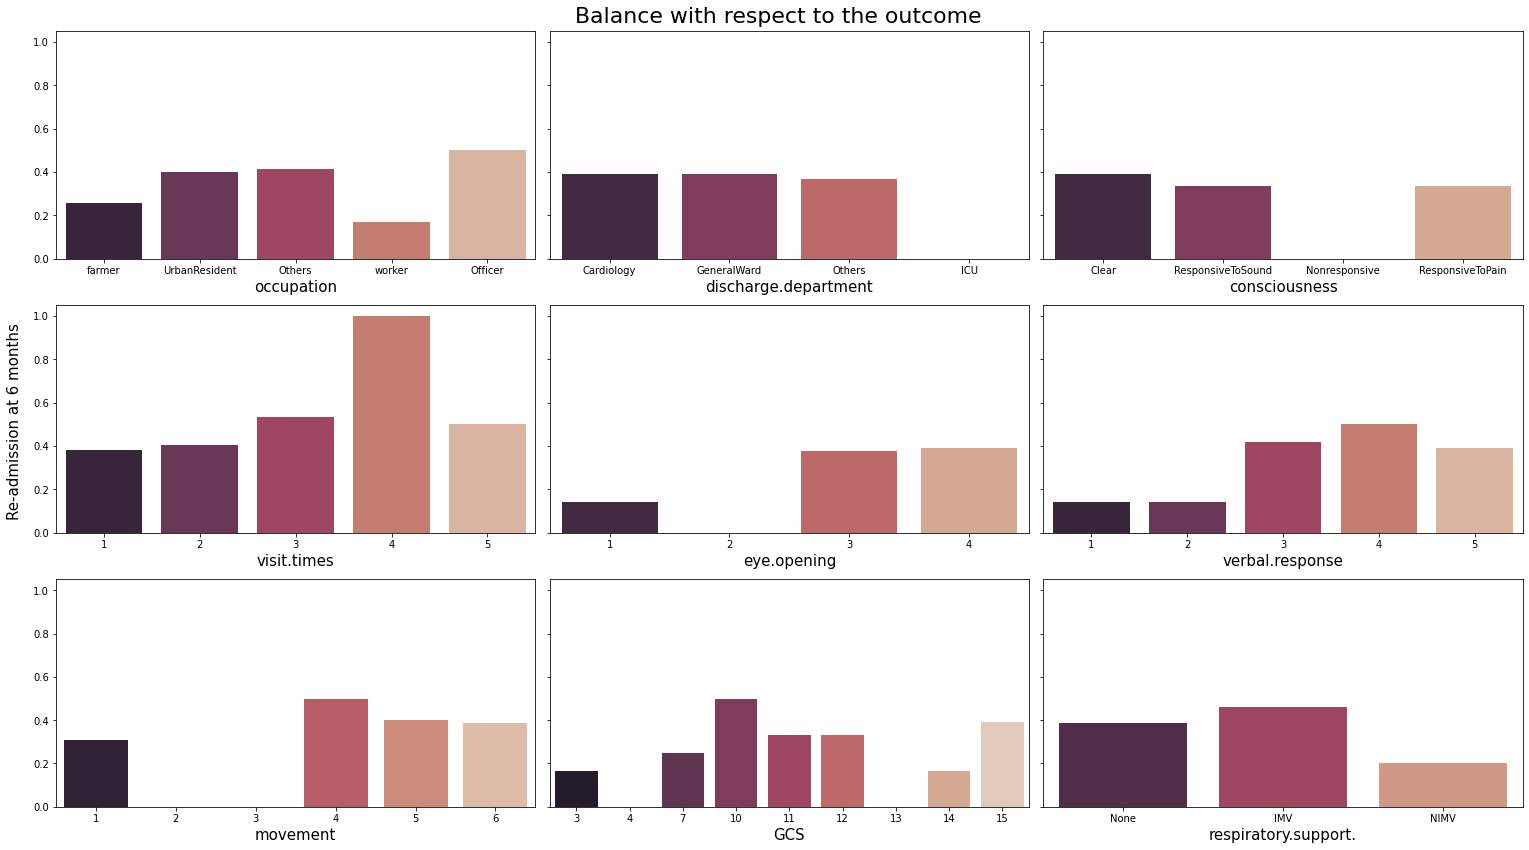

In [28]:
group1 = ['occupation', 'discharge.department', 'consciousness','visit.times', 'eye.opening', 
          'verbal.response','movement', 'GCS', 'respiratory.support.']

fig, axes = plt.subplots(3,3,sharey=True, figsize=(21,12))
fig.text(-0.01, 0.5, 'Re-admission at 6 months', va='center', rotation='vertical', size = 15)
fig.suptitle('Balance with respect to the outcome', size = 22)

idx = 0
i = 0
for column_name in group1:
    
    sns.barplot(ax=axes[i,idx], x=column_name, y= outcome_name,
                data=X_train, saturation=.5, ci=None, palette='rocket')
    axes[i,idx].set_ylabel('')
    axes[i,idx].set_xlabel(column_name, size = 15)
    idx += 1
    if idx == 3:
        idx = 0
        i += 1

fig.tight_layout()
plt.show()

From this, we can see that some of the variables like 'eye.opening', 'verbal.response', 'movement', 'GCS', 'discharge department','consciousness' have some categories which are never present when the outcome is. For this reason, we will keep them for the models we will develop.

In [29]:
balanced_in_outcome.extend(['occupation','visit.times','respiratory.support.'])

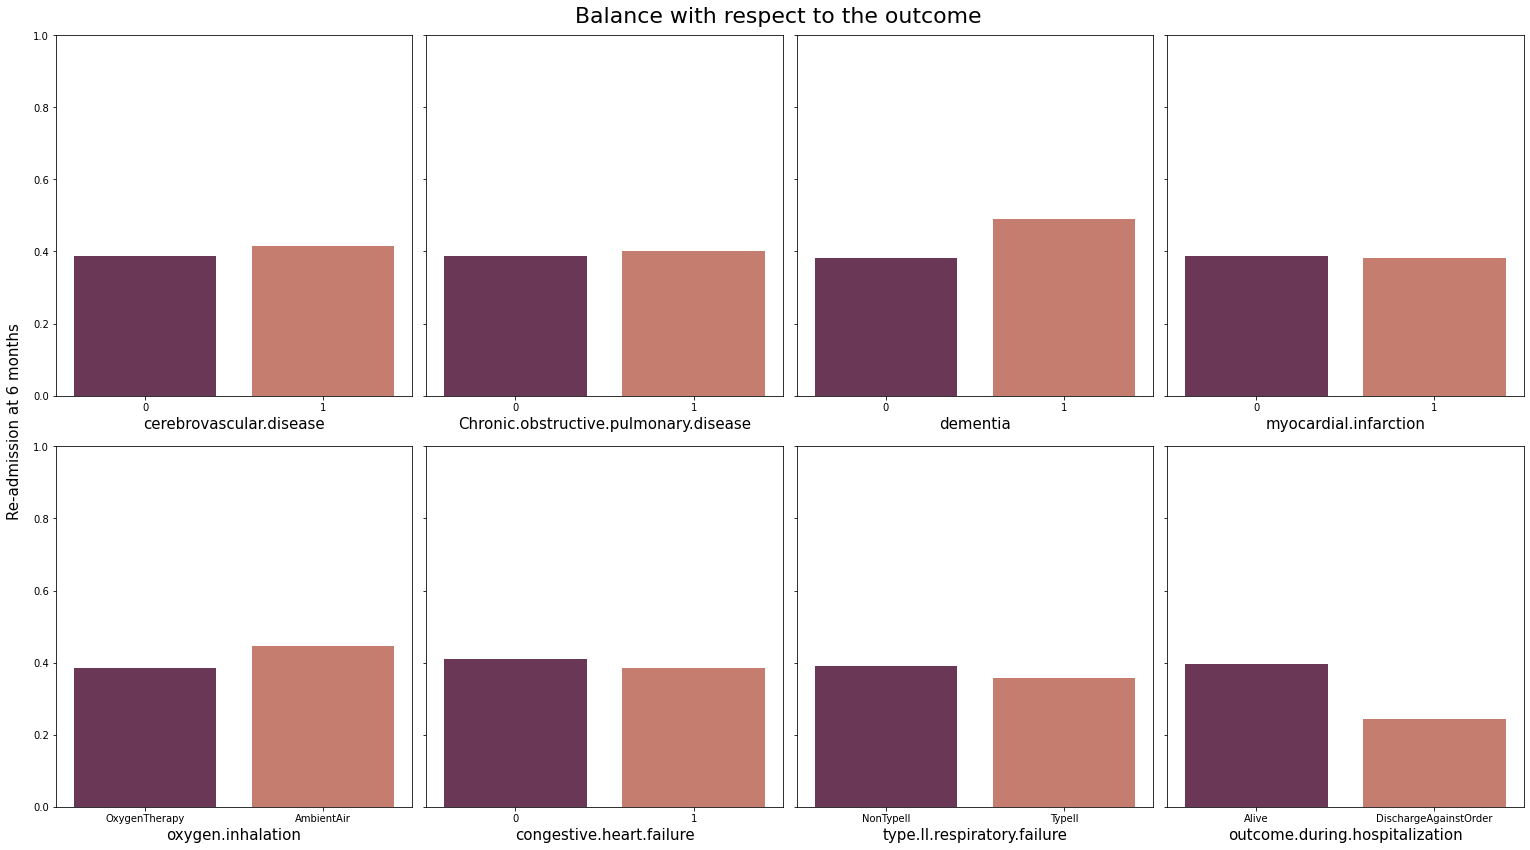

In [30]:
group2 = list(set(unbalanced_cols) - set(group1))

fig, axes = plt.subplots(2,4,sharey=True, figsize=(21,12))
fig.text(-0.01, 0.5, 'Re-admission at 6 months', va='center', rotation='vertical', size = 15)
fig.suptitle('Balance with respect to the outcome', size = 22)

idx = 0
i = 0
for column_name in group2:
    
    sns.barplot(ax=axes[i,idx], x=column_name, y= outcome_name,
                data=X_train, saturation=.5, ci=None, palette='rocket')
    axes[i,idx].set_ylabel('')
    axes[i,idx].set_xlabel(column_name, size = 15)
    idx += 1
    if idx == 4:
        idx = 0
        i += 1
        
plt.ylim([0,1])
fig.tight_layout()
plt.show()

We can see that all the binary variables have a balanced proportion of values in their categories corresponding to the outcome class. Thus, we can think of removing these variables from the study.

In [31]:
balanced_in_outcome.extend(group2)

In [32]:
X_train.drop(columns = balanced_in_outcome, inplace = True)
print(f"Current number of features in training: {X_train.shape[1]}")

Current number of features in training: 87


In [33]:
X_test.drop(columns = balanced_in_outcome, inplace = True)
print(f"Current number of features in test: {X_test.shape[1]}")

Current number of features in test: 87


In [34]:
# now we should adjust the lists of variables 

categorical_columns = ['DestinationDischarge','admission.ward','admission.way','discharge.department',
                       'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',
                       'consciousness', 'ageCat']

ordinal_columns = ['CCI.score', 'eye.opening','verbal.response', 'movement', 'GCS']

not_continuous = categorical_columns.copy()

binary_columns = ['gender', 'diabetes', 'moderate.to.severe.chronic.kidney.disease',
                  're.admission.within.28.days', 're.admission.within.3.months', 
                  're.admission.within.6.months', 'return.to.emergency.department.within.6.months']

not_continuous.extend(binary_columns)
not_continuous.extend(ordinal_columns)

## Binary variables to {0,1}

In [35]:
X_train['gender'].value_counts()

Female    914
Male      658
Name: gender, dtype: int64

In [36]:
X_train['gender'] = [1 if elem=='Male' else 0 for elem in X_train['gender']]

In [37]:
X_test['gender'] = [1 if elem=='Male' else 0 for elem in X_test['gender']]

In [38]:
# Convert CCI.score to int -- doesn't work
# data_new["CCI.score"].loc[data_new["CCI.score"].notnull()] = data["CCI.score"].loc[data["CCI.score"].notnull()].astype(int).values

# Continuous variables and correlation analysis

We will plot the correlation matrix just to have an idea of the possible groups of features that have a high (positive or negative) correlation. But clearly there are too many continuous variables to get a clear understading from this.

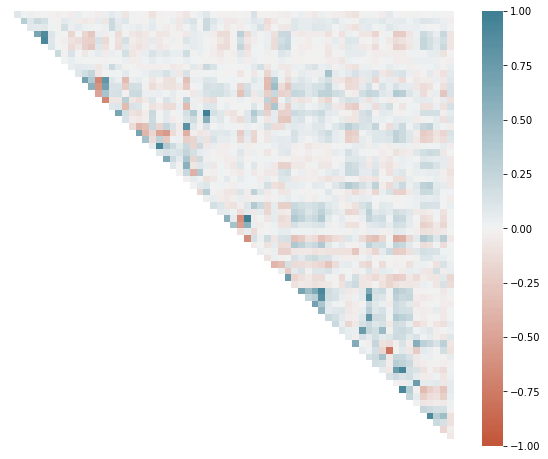

In [39]:
plt.figure(figsize=(10,8))
cor_matrix = X_train[continuous_columns].corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))
sns.heatmap(cor_matrix, mask = mask, xticklabels = False, yticklabels = False, vmin=-1, vmax=1, center = 0,
            cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

In [40]:
highly_corr_features = np.where(np.abs(cor_matrix) > 0.9)
coupled_features = zip(highly_corr_features[0],highly_corr_features[1])

ls = []
ls_names = []
# list of tuples of correlated features -- recover the names from correlation matrix
for elem1,elem2 in coupled_features:
    # exclude the couples with the same feature (corr = 1) and the couple already present in the list
    if elem1 != elem2 and (elem2,elem1) not in ls:
        ls.append((elem1,elem2))
        ls_names.append((cor_matrix.iloc[:,elem1].name,cor_matrix.iloc[:,elem2].name))

In [41]:
ls

[(4, 5), (15, 29), (20, 22), (31, 35), (42, 46), (54, 58), (57, 58)]

In [42]:
ls_names

[('diastolic.blood.pressure', 'map'),
 ('white.blood.cell', 'neutrophil.count'),
 ('mean.corpuscular.volume', 'mean.hemoglobin.volume'),
 ('international.normalized.ratio', 'prothrombin.time.ratio'),
 ('hydroxybutyrate.dehydrogenase', 'lactate.dehydrogenase'),
 ('indirect.bilirubin', 'total.bilirubin'),
 ('direct.bilirubin', 'total.bilirubin')]

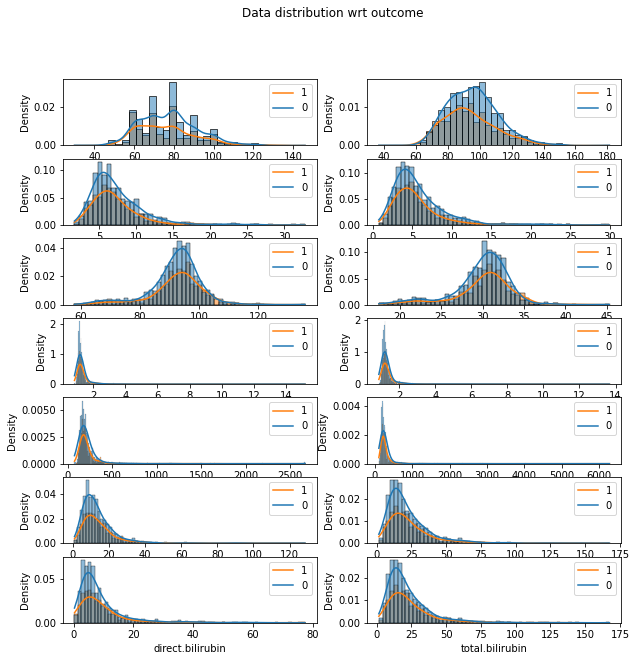

In [43]:
fig, axes = plt.subplots(len(ls_names), 2,figsize=(10, 10))
fig.suptitle('Data distribution wrt outcome')

for i,tup in enumerate(ls_names):
    
    sns.histplot(X_train, x=tup[0], kde=True, stat = 'density', ax = axes[i,0], hue=outcome_name)
    axes[i,0].legend(labels=['1', '0'])
    sns.histplot(X_train, x=tup[1], kde=True, stat = 'density', ax = axes[i,1], hue=outcome_name)
    axes[i,1].legend(labels=['1', '0'])
    
plt.show()

From this plot we can see that all couples of correlated features present a difference in the distributions of patients which were readmitted after 6 months and those who were not. We will now analyze these highly correlated features on the basis of domain knowledge to decide which ones to keep.

### Analysis of the highly correlated features:

In [44]:
col_to_drop = []

In [45]:
cor_matrix = X_train.loc[:,['diastolic.blood.pressure', 'map']].corr()
cor_matrix

,diastolic.blood.pressure,map
diastolic.blood.pressure,1.000000,0.924812
map,0.924812,1.000000


We keep the feature 'diastolic.blood.pressure' since the 'map' (Mean Arterial Pressure) synthesises the systolic and dyastolic blood pressures and so we already have this information.

In [46]:
col_to_drop = ['map']

In [47]:
cor_matrix = X_train.loc[:,['white.blood.cell', 'neutrophil.count']].corr()
cor_matrix

,white.blood.cell,neutrophil.count
white.blood.cell,1.000000,0.977833
neutrophil.count,0.977833,1.000000


We drop 'white.blood.cell' since we have already a variable that gives us information about white cells.

In [48]:
col_to_drop.append('white.blood.cell')

In [49]:
cor_matrix = X_train.loc[:,['mean.corpuscular.volume', 'mean.hemoglobin.volume']].corr()
cor_matrix

,mean.corpuscular.volume,mean.hemoglobin.volume
mean.corpuscular.volume,1.000000,0.940252
mean.hemoglobin.volume,0.940252,1.000000


We take 'mean.corpuscular.volume' since it has a better distribution as we can see in the file 1_Data processing and cleaning

In [50]:
col_to_drop.append('mean.hemoglobin.volume')

In [51]:
cor_matrix = X_train.loc[:,['international.normalized.ratio', 'prothrombin.time.ratio']].corr()
cor_matrix

,international.normalized.ratio,prothrombin.time.ratio
international.normalized.ratio,1.000000,0.997146
prothrombin.time.ratio,0.997146,1.000000


We take 'prothrombin.time.ratio' since the 'international.normalized.ratio' is computed from the other one.

In [52]:
col_to_drop.append('international.normalized.ratio')

In [53]:
cor_matrix = X_train.loc[:,['hydroxybutyrate.dehydrogenase', 'lactate.dehydrogenase']].corr()
cor_matrix

,hydroxybutyrate.dehydrogenase,lactate.dehydrogenase
hydroxybutyrate.dehydrogenase,1.000000,0.921708
lactate.dehydrogenase,0.921708,1.000000


3-hydroxybutyrate dehydrogenase is an enzyme belonging to the class of oxidoreductases, which catalyzes the following reaction:

(D)-3-hydroxybutanoate + NAD+ ⇄ acetoacetate + NADH + H+

L-lactate dehydrogenase (or LDH) is an enzyme, belonging to the class of oxidoreductases, which catalyzes the following reaction:

(L)-lactate + NAD+ ⇄ pyruvate + NADH + H+

We notice that these two enzymes catalyze indeed very similar chemical reactions, so we can explain ourselves the big correlation between the two. We decide to keep only the lactate.dehydrogenase.

In [54]:
col_to_drop.append('hydroxybutyrate.dehydrogenase')

In [55]:
cor_matrix = X_train.loc[:,['indirect.bilirubin', 'total.bilirubin']].corr()
cor_matrix

,indirect.bilirubin,total.bilirubin
indirect.bilirubin,1.00000,0.93821
total.bilirubin,0.93821,1.00000


In [56]:
cor_matrix = X_train.loc[:,['direct.bilirubin', 'total.bilirubin']].corr()
cor_matrix

,direct.bilirubin,total.bilirubin
direct.bilirubin,1.000000,0.928215
total.bilirubin,0.928215,1.000000


We drop the 'total.bilirubin' since is the sum of the indirect and direct bilirubin.

In [57]:
col_to_drop.append('total.bilirubin')

### Deleting columns

In [58]:
indici_28days=X_train[X_train["re.admission.within.28.days"]==1].index

In [59]:
indici_3months=list(X_train[X_train["re.admission.within.3.months"]==1].index)

In [60]:
indici_6months=list(X_train[X_train["re.admission.within.6.months"]==1].index)

In [61]:
value_mancanti=[]
value_mancanti = [col_name for col_name in indici_28days if col_name not in indici_6months]
value_mancanti

[837990]

In [62]:
value_mancanti = [col_name for col_name in indici_6months if col_name not in indici_6months]
value_mancanti

[]

In [65]:
X_train.loc[837990,"re.admission.within.6.months"]=1

In [64]:
col_to_drop.append('re.admission.within.28.days')
col_to_drop.append('re.admission.within.3.months')

#### We drop the column that are correlated

In [66]:
train_data = X_train.copy()
train_data.drop(col_to_drop, axis=1, inplace = True)
print(f"Current number of features of training set: {train_data.shape[1]}")

Current number of features of training set: 79


In [67]:
test_data = X_test.copy()
test_data.drop(col_to_drop, axis=1, inplace = True)
print(f"Current number of features of test set: {test_data.shape[1]}")

Current number of features of test set: 79


In [68]:
train_data.to_csv('train_data.csv')

In [69]:
test_data.to_csv('test_data.csv')